# **Intro CVAE**
In this notebook I use a conditional variational autoencoder (CVAE) in order to determine the single-cell perturbation effect.
The VAE is conditioned on the sample ID and perturbation status.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb


# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

num_genes = 7000

exp_id = "mono-kang"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id)
X_full.columns = gene_df

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [5]:
np.sort(X_colmean)

array([0.0, 0.0, 0.0, ..., 805066.7128640777, 1589126.2970873786,
       1683903.2968446603], dtype=object)

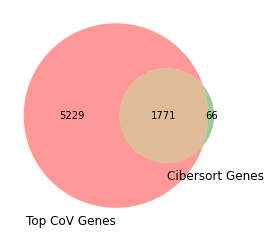

In [6]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [7]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [8]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [9]:
X_full = X_full.loc[:,union_genes]


## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_cvae = X_full[idx_train,]
label_cvae = label_full[idx_train,]
drug_cvae = drug_full[idx_train,]
y_cvae = Y_full.iloc[idx_train,]




In [10]:
X_train

array([[165, 510, 8, ..., 0, 0, 0],
       [142, 932, 2, ..., 0, 0, 0],
       [506, 1584, 0, ..., 0, 0, 0],
       ...,
       [36, 200, 0, ..., 0, 0, 0],
       [27, 352, 0, ..., 0, 0, 0],
       [36, 303, 0, ..., 0, 0, 0]], dtype=object)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.162s...
[t-SNE] Computed neighbors for 17320 samples in 15.707s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for s

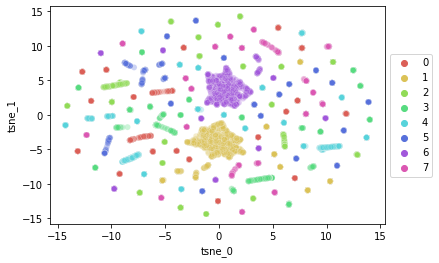

In [11]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **M2 Model Definition**

## Hyperparameters

In [12]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

beta_kl =  10 ###

n_x = X_full.shape[1]
n_drug = drug_full.shape[1]
n_label = label_full.shape[1]
n_z = 202  # 64+64+64+10 same as BuDDI


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
encoder_dim1 = 784 # dim of encoder hidden layer 1
encoder_dim2 = 512 # dim of encoder hidden layer 512 
decoder_dim1 = 512 # dim of encoder hidden layer 512 
decoder_dim2 = 784 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

activ = 'relu'
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of drug {n_label} ")



length of X 7066 and length of drug 8 


## Encoder + Y classifier

In [13]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Drug = Input(shape=(n_drug,))
Label = Input(shape=(n_label,))

inputs = concat([X, Label, Drug])

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_1 = Dense(encoder_dim1, activation=activ, name="encoder_1")(inputs)
encoder_2 = Dense(encoder_dim2, activation=activ, name="encoder_2")(encoder_1)


# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_2)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_2)



## Latent Space

In [14]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])

z_concat = concat([z_slack, Label, Drug])


## Decoder + Classifiers

In [15]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden1 = Dense(decoder_dim1, activation=activ, name = "decoder_h1")
decoder_hidden2 = Dense(decoder_dim2, activation=activ, name = "decoder_h2")


# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

dh_p1 = decoder_hidden1(z_concat)
dh_p2 = decoder_hidden2(dh_p1)
outputs = decoder_out(dh_p2)


d_in = Input(shape=(n_z+n_label+n_drug,))
d_h1 = decoder_hidden1(d_in)
d_h2 = decoder_hidden2(d_h1)
d_out = decoder_out(d_h2)



## Loss

In [16]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_slack = beta_kl * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)



## Make the computational graph

In [17]:
cvae = Model([X, Label, Drug], outputs)
encoder = Model([X, Label, Drug], z_slack)


decoder = Model(d_in, d_out)


print(cvae.summary())
print(encoder.summary())
print(decoder.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7066)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7076)         0           ['input_1[0][0]',                
                                                                  'input_3[0][0]',            

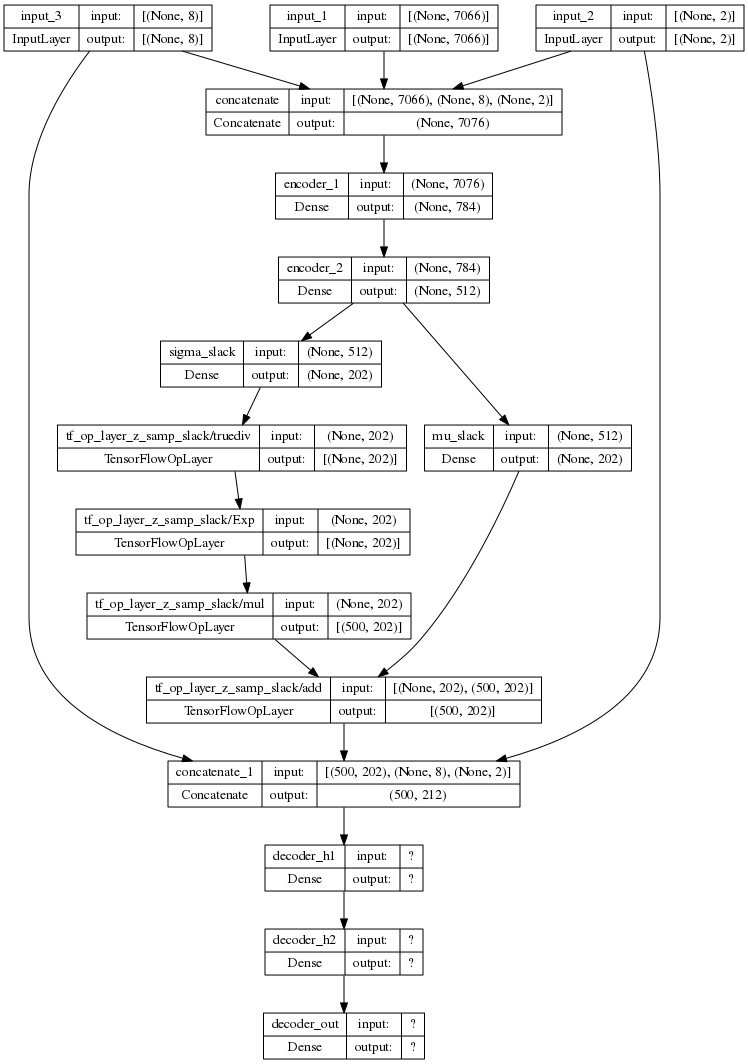

In [18]:
display(plot_model(cvae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [19]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [recon_loss])

In [20]:
cvae_hist = cvae.fit([np.repeat(X_cvae, 100, axis=0), 
                      np.repeat(label_cvae, 100, axis=0), 
                      np.repeat(drug_cvae, 100, axis=0)], 
                    np.repeat(X_cvae, 100, axis=0), verbose = 1, batch_size=batch_size, epochs=5)

Train on 412000 samples
Epoch 1/5
412000/412000 [==============================] - 79s 191us/sample - loss: 20.1875 - recon_loss: 18.7943
Epoch 2/5
412000/412000 [==============================] - 80s 195us/sample - loss: 17.3308 - recon_loss: 17.3308
Epoch 3/5
412000/412000 [==============================] - 79s 193us/sample - loss: 16.9937 - recon_loss: 16.9937
Epoch 4/5
412000/412000 [==============================] - 79s 192us/sample - loss: 16.9478 - recon_loss: 16.9478
Epoch 5/5
412000/412000 [==============================] - 79s 191us/sample - loss: 16.9393 - recon_loss: 16.9393


Now train

In [21]:
cvae_hist.history.keys()

dict_keys(['loss', 'recon_loss'])

# Plot Loss Curves

In [22]:
# write out the loss for later plotting
# unpack the loss values
total_loss = cvae_hist.history['loss']
recon_loss = cvae_hist.history['recon_loss']



# make into a dataframe
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['batch'] = [*range(len(total_loss))]
loss_df['recon_loss'] = recon_loss



In [23]:
loss_df

,total_loss,batch,recon_loss
0,20.187532,0,18.794258
1,17.330785,1,17.330770
2,16.993727,2,16.993731
3,16.947782,3,16.947788
4,16.939261,4,16.939257


In [24]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

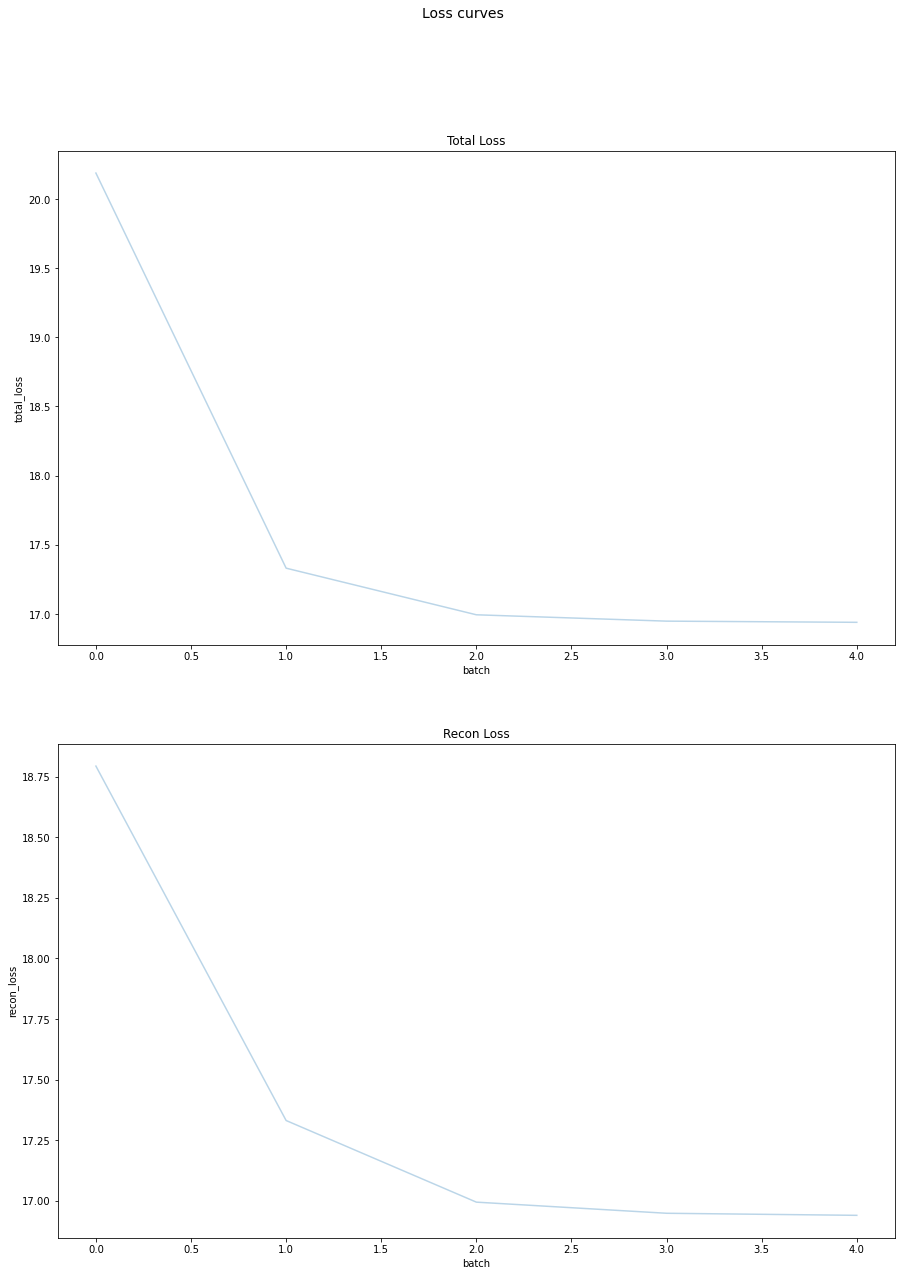

In [25]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)


fig, axs = plt.subplots(2, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="recon_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [26]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [27]:
Label_full.shape

(17320,)

In [28]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full

recon_idx = np.logical_and(meta_df.cell_prop_type == "realistic", meta_df.isTraining == "Test")
recon_idx = np.where(recon_idx)[0]
recon_len = len(recon_idx)
recon_idx = np.tile(recon_idx, 5)

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the encoder to get the latent spaces
X_temp = X_temp[recon_idx]

# now use the encoder to get the latent spaces
mu_slack = encoder.predict([X_temp, label_temp, perturb_temp], batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([mu_slack, label_temp, perturb_temp])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


decoded_outputs = decoded_outputs[range(recon_len)]
X_temp = X_temp[range(recon_len)]
label_num = label_num[range(recon_len)]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1200, 2)
(1200, 2)


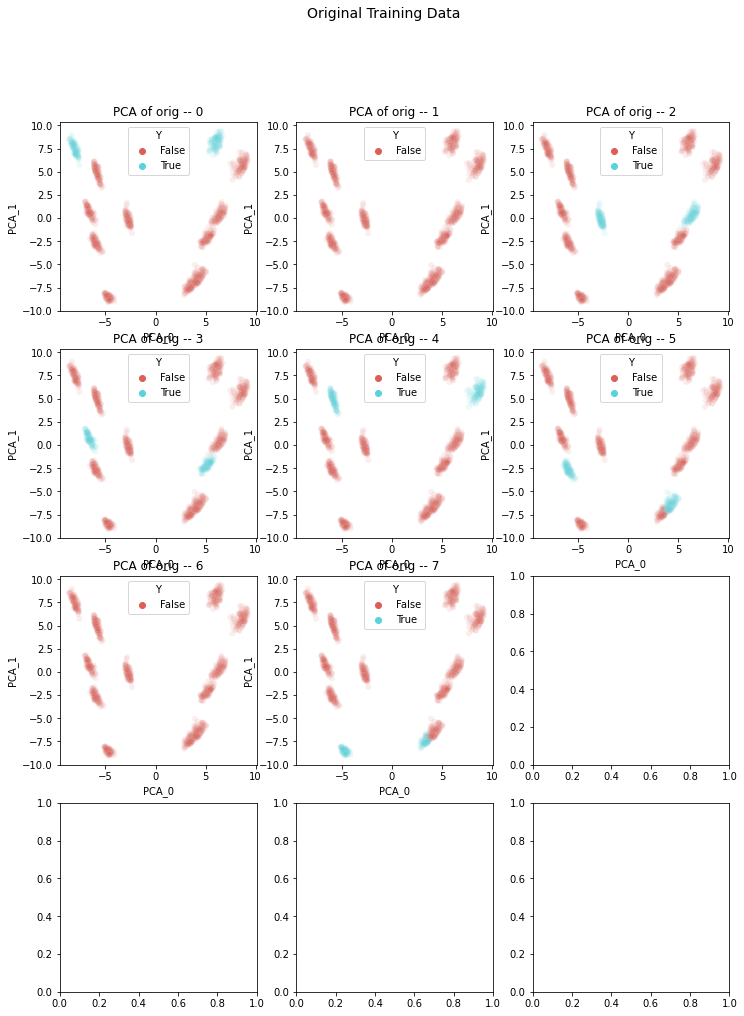

In [29]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=label_num==0, ax=axs[0,0], title="PCA of orig -- 0")
vp.plot_pca(plot_df, color_vec=label_num==1, ax=axs[0,1], title="PCA of orig -- 1")
vp.plot_pca(plot_df, color_vec=label_num==2, ax=axs[0,2], title="PCA of orig -- 2")
vp.plot_pca(plot_df, color_vec=label_num==3, ax=axs[1,0], title="PCA of orig -- 3")
vp.plot_pca(plot_df, color_vec=label_num==4, ax=axs[1,1], title="PCA of orig -- 4")
vp.plot_pca(plot_df, color_vec=label_num==5, ax=axs[1,2], title="PCA of orig -- 5")
vp.plot_pca(plot_df, color_vec=label_num==6, ax=axs[2,0], title="PCA of orig -- 6")
vp.plot_pca(plot_df, color_vec=label_num==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(1200, 2)
(1200, 2)


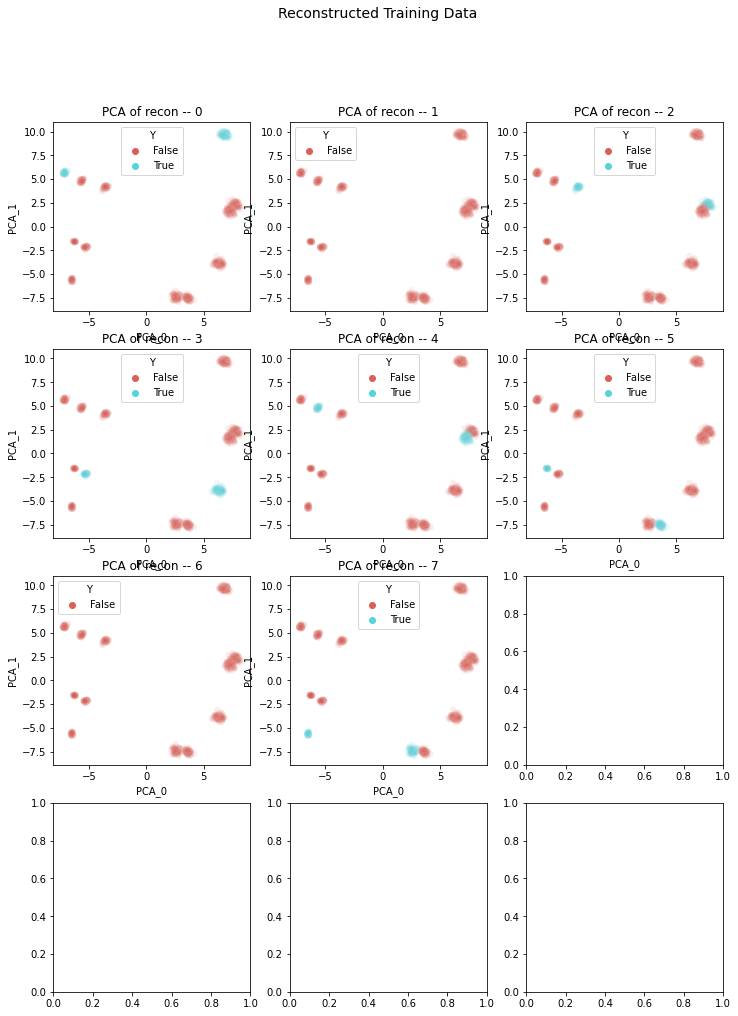

In [30]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=label_num==0, ax=axs[0,0], title="PCA of recon -- 0")
vp.plot_pca(plot_df, color_vec=label_num==1, ax=axs[0,1], title="PCA of recon -- 1")
vp.plot_pca(plot_df, color_vec=label_num==2, ax=axs[0,2], title="PCA of recon -- 2")
vp.plot_pca(plot_df, color_vec=label_num==3, ax=axs[1,0], title="PCA of recon -- 3")
vp.plot_pca(plot_df, color_vec=label_num==4, ax=axs[1,1], title="PCA of recon -- 4")
vp.plot_pca(plot_df, color_vec=label_num==5, ax=axs[1,2], title="PCA of recon -- 5")
vp.plot_pca(plot_df, color_vec=label_num==6, ax=axs[2,0], title="PCA of recon -- 6")
vp.plot_pca(plot_df, color_vec=label_num==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(2400, 2)
(2400, 2)


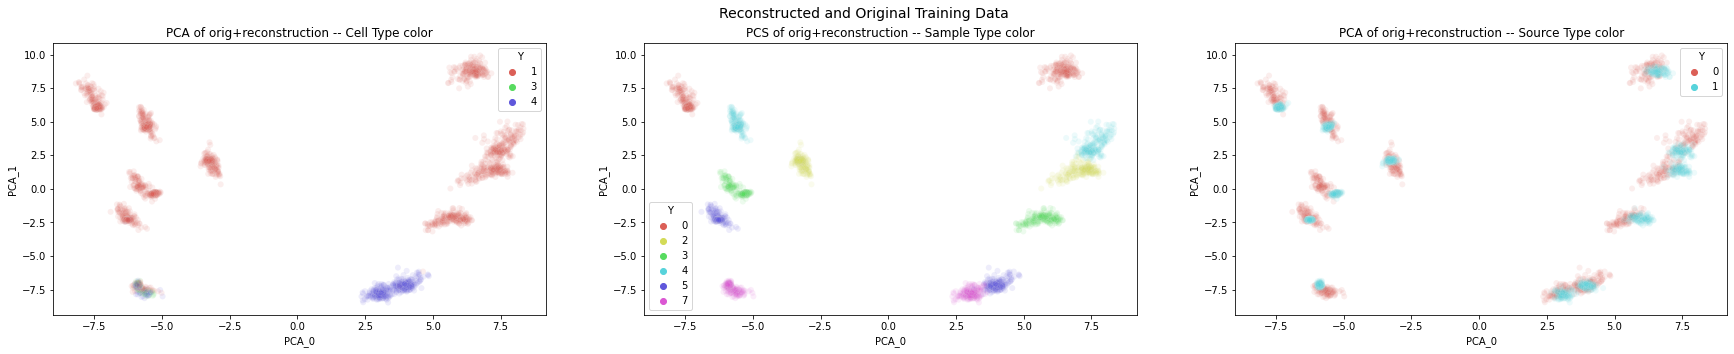

In [31]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])

perturb_temp = perturb_temp[range(recon_len)]
Y_temp = Y_temp[range(recon_len)]


Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*1200, [1]*1200))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

### drug perturbation

In [32]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)


<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [33]:

# run first the cell_type specific things

cell_type_specific_r2 = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']


ctrl_test_meta_df, decoded_0_0, decoded_0_1 = vp.calc_CVAE_perturbation(X_full, meta_df, encoder, decoder, 
                                                                        scaler, batch_size, 
                                                                        label_full, drug_full)
decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)

for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, ctrl_test_meta_df,
                                                                                        curr_cell_type)

        expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse'])

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
        else:
             cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])


# now run the realistic ones

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [34]:
cell_type_specific_r2

,sample_id,cell_type,bulk_type,expr_r2,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse
0,101,B,cell_type_specific,0.738735,0.679423,0.520245,0.770611,0.870568,1.686629
0,101,CD14_Mono,cell_type_specific,0.945952,0.535654,0.388376,0.614650,0.802711,2.452208
0,101,CD16_Mono,cell_type_specific,0.868795,0.670295,0.504807,0.755763,0.884937,1.675100
0,101,CD4_Mem_T,cell_type_specific,0.759535,0.677598,0.519306,0.769116,0.865797,1.716474
0,101,CD4_Naive_T,cell_type_specific,0.608872,0.679196,0.534588,0.769683,0.846548,1.705075
0,101,CD8_T,cell_type_specific,0.692435,0.680290,0.524579,0.770476,0.862204,1.697535
0,101,DC,cell_type_specific,0.770580,0.667419,0.516966,0.758827,0.859870,1.675545
0,101,Mk,cell_type_specific,0.579478,0.676834,0.526211,0.770481,0.839751,1.697390
0,101,NK,cell_type_specific,0.656032,0.681250,0.527567,0.775824,0.852715,1.724380
0,101,T_Act,cell_type_specific,0.674253,0.670838,0.524748,0.762698,0.836654,1.708133


In [35]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_CVAE.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)
